### Demo for using fuzzy-mining
#### created by Shray Pungaliya (forked from Fanqing Xu), supervised by Mohammad Reza Rajati

In [2]:
import fuzzy_mining as fm### Demo for using fuzzy-mining
import pandas as pd
from sklearn.model_selection import train_test_split
from skfuzzy import control as ctrl
import skfuzzy as fuzz
from skfuzzy import fuzzy_sub
# %matplotlib inline
import matplotlib.pyplot as plt
from collections import defaultdict
from dataclasses import dataclass
import numpy as np

import sys, importlib
importlib.reload(sys.modules['fuzzy_mining'])
import fuzzy_mining as fm

/Users/shray/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
# import dataset as pandas dataframe
# we use a simple regression problem dataset for example:
# https://archive.ics.uci.edu/ml/datasets/concrete+compressive+strength
dataset = pd.read_excel('./data/Concrete_Data.xls')

In [4]:
# split the dataset into training/test set as you like
X_train, X_test = train_test_split(dataset, test_size=0.3, random_state=0)
# specify the names for Antecedents and Consequent
column_names = ["cement", "slag", "ash", "water", "superplasticizer", "coarse_aggregate", "fine_aggregate", "age", "strength"]

In [5]:
# create the Fuzzy Object using training dataset and names
concrete = fm.FuzzyObj(X_train, column_names)

In [6]:
# define the range of each component
concrete.create_fuzzy_variables()

Fuzzy variables are created with 8 Antecedents and 1 Consequent:
[Antecedent: cement, Antecedent: slag, Antecedent: ash, Antecedent: water, Antecedent: superplasticizer, Antecedent: coarse_aggregate, Antecedent: fine_aggregate, Antecedent: age, Consequent: strength]


Fuzzification is done. View membership function using .view(name, region):
Regions are: ['low', 'medium', 'high']
Preview of Consequent y:



/Users/shray/.pyenv/versions/3.8.2/lib/python3.8/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


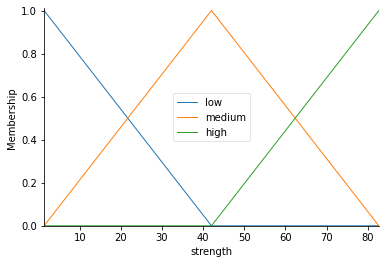

In [7]:
# fuzzify each component
# for now, only auto_fuzzify is supported and recommmended
# you can view the fuzzy region for each component
region_names = ['low', 'medium', 'high']
regionNameLen = len(region_names)
concrete.auto_fuzzify(region_names)

In [8]:
# extract the rules from training data
# group the rules with same IF part together
concrete.extract()

137 unique rules(groups) are found.


In [9]:
# for each group, resolve the conflicting rules
# accepted method arguments are: 'random', 'majority', 'ranked', 'WMcomplete', 'semiavg'
concrete.resolve_conflict(method='majority')

137 final rules are built.


In [10]:
# for extra dataset, like test data, there may no exist exact matched rules in rule base.
# we have to interpolate the rule base to make it work.
# accepted metric arguements are: 'Jaccard', 'plain' (for now, only nearest neigbhor method)
concrete.interp_rules(X_test, method='Jaccard')

['low', 'medium', 'low', 'medium', 'low', 'low', 'low', 'low', 'low']
9 extra rules are added after interpolation.


In [11]:
# you can check how interpolated rules are like
# each rule is in shape: [x1, x2, ..., y]
concrete.extra_rules[0]

['medium',
 'medium',
 'low',
 'medium',
 'medium',
 'high',
 'medium',
 'medium',
 'medium']

In [12]:
# you can also check how original rule base is like (which extract only from training dataset)
concrete.rule_base[0]

['medium', 'low', 'low', 'medium', 'low', 'medium', 'medium', 'low', 'medium']

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

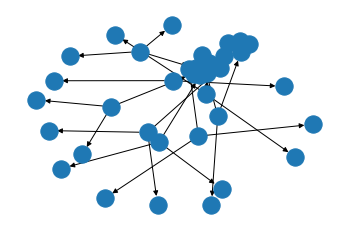

In [13]:
'''
This part can't be integrate into the package, which needs to be explicitly written, for now.
The main purpose is to use rule base and extra rules we have obtained to construct the Rule objects,
which is a must in scikit-fuzzy package.
'''

# .Rule() method also accepts Term
rules = []
ant_con = concrete.list_obj
for r in concrete.rule_base:
    rules.append(ctrl.Rule(ant_con[0][r[0]] & ant_con[1][r[1]] & ant_con[2][r[2]]
                  & ant_con[3][r[3]] & ant_con[4][r[4]] & ant_con[5][r[5]] 
                  & ant_con[6][r[6]] & ant_con[7][r[7]], ant_con[8][r[8]]))
# add extra interpolated rules
for r in concrete.extra_rules:
    rules.append(ctrl.Rule(ant_con[0][r[0]] & ant_con[1][r[1]] & ant_con[2][r[2]]
                  & ant_con[3][r[3]] & ant_con[4][r[4]] & ant_con[5][r[5]] 
                  & ant_con[6][r[6]] & ant_con[7][r[7]], ant_con[8][r[8]]))
# you can check a visualization of rule by .view() 
# (porvided by scikit-fuzzy, showing some relation between components)
rules[0].view()

In [14]:
# now, we can build the fuzzy system using Rules obtained above
# this will take some time
concrete.build_system(rules)

This will take a fairly long time, caused by graph creating process which is used in scikit-fuzzy package.

Done. Time used to build fuzzy system: 20.521998 sec.


In [15]:
# Work by Shray Pungaliya (pungaliy) from this point forward. Unfortunately, Concrete data set is way too large to
# do the necessary computations for similarity decision rules, so this program just hangs. Using a smaller data set
# or finding points at which the program can be made more efficient is the only way to make this work well.

fuzzyObject = concrete
U = 1
dataset_name = 'concrete'
transitionPairs = fuzzyObject.getDefaultTransitionPairs()
print(transitionPairs)
# This part is expensive because fuzzy subtraction is very slow; 
# However, the method creates and saves a pickle file so it doesn't recompute the same thing each time
delta_u_consequent = fuzzyObject.genSubtractionConsequent(column_names[U], transitionPairs, dataset_name)

{'low': 'medium', 'medium': 'high', 'high': 'high'}
Retrieving saved fuzzy subtraction results


Jaccard similarities for 3896 rules


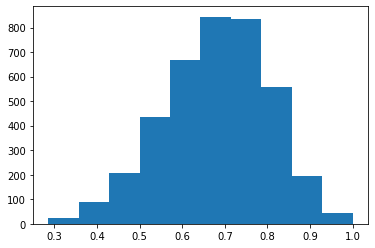

Maximum values of trapezoidal mf for 3896 rules


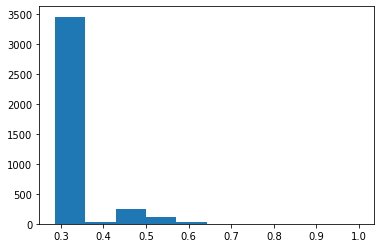

Threshold set at 0, so only 7792 rules placed in control system


KeyboardInterrupt: 

In [16]:
# A local machine may not be able to handle this if the threshold is too low, but a low threshold is necessary
# In fact, the only reason to use a higher threshold I found was for testing purposes. Please avoid using it
# Note that a high threshold will yield results leading to a mean change of 0
similarityDecisionControlSystem = fuzzyObject.generateSimilarityDecisionControlSystem(transitionPairs, U, delta_u_consequent, threshold=0)

In [ ]:
from sklearn.neural_network import MLPRegressor
# separate label from X_train using above
train_X = X_train.loc[:,X_train.columns[0:len(ant_con)-1]].to_numpy()
train_y = X_train.loc[:,X_train.columns[-1]].to_numpy()
test_X = X_test.loc[:,X_test.columns[0:len(ant_con)-1]].to_numpy()
test_y = X_test.loc[:,X_test.columns[-1]].to_numpy()

regr = MLPRegressor(hidden_layer_sizes=(50,), max_iter=500, random_state=0)

regr.fit(train_X, train_y)



decisionControlSystem = similarityDecisionControlSystem
# train
new_train_X = fuzzyObject.generateNewX(train_X, decisionControlSystem, U)
new_train_y = regr.predict(new_train_X)
train_delta_ys = np.subtract(new_train_y, train_y)

# test
new_test_X = fuzzyObject.generateNewX(test_X, decisionControlSystem, U)
new_test_y = regr.predict(new_test_X)
test_delta_ys = np.subtract(new_test_y, test_y)


In [ ]:
from scipy import stats

print("Decision variable: " + column_names[U])

print("train_delta_ys")
plt.hist(train_delta_ys)
print(stats.describe(train_delta_ys))
plt.show()

print("test_delta_ys")
plt.hist(test_delta_ys)
print(stats.describe(test_delta_ys))
plt.show()